# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tableone import TableOne
import torch
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization

from synthcity.metrics.plots import plot_tsne
from synthcity.metrics.eval import Metrics
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "SAS_1"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
control = pd.read_csv(data_file_control, header=None, names=control_fnames)
print(control.head())

    time  censor  SEX   AGE  B_WGTN  B_ECOGN  B_LDHN  B_HGB  BSEPON  MEDHINTN  \
0   97.0     1.0    1  39.0     0.0      0.0     0.0   31.0     0.0       0.0   
1  494.0     1.0    1  27.0     0.0      0.0     1.0    2.0     0.0       0.0   
2  234.0     1.0    1  41.0     1.0      0.0     0.0   29.0     0.0       0.0   
3  180.0     1.0    0  26.0     1.0      0.0     1.0   25.0     0.0       0.0   
4  647.0     0.0    0  13.0     1.0      0.0     0.0   83.0     0.0       0.0   

   PRTFN  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  


In [4]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)

In [5]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [6]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

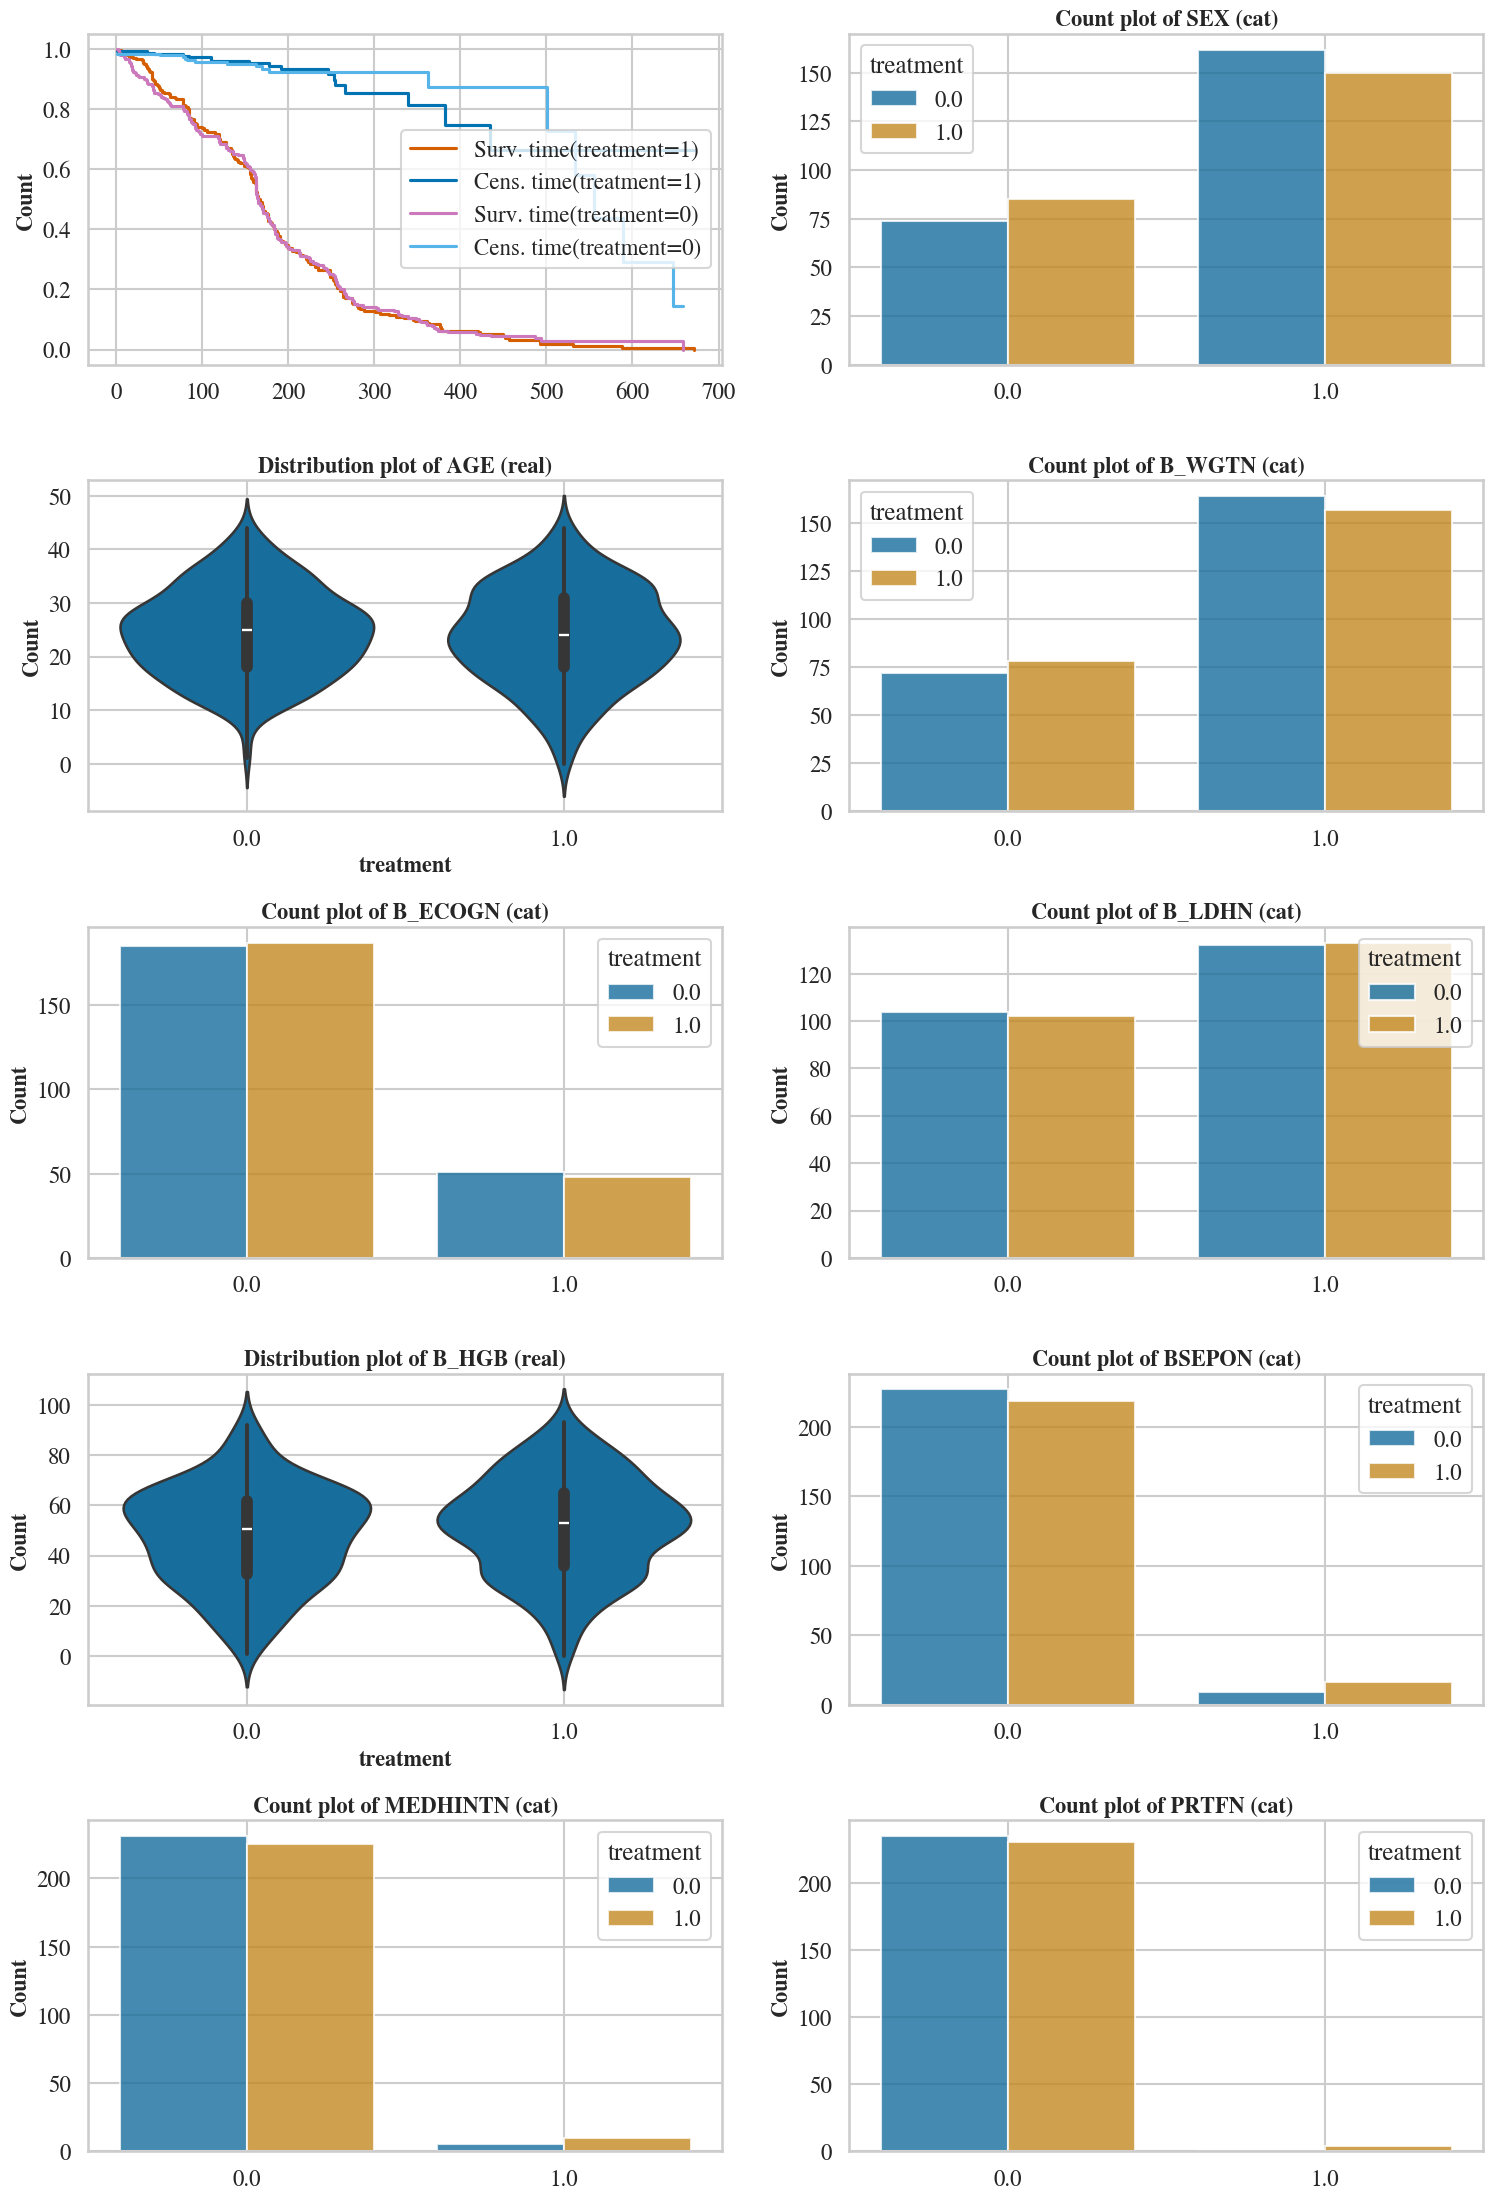

In [7]:
# TODO: Refactor
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [8]:
categorical = ['censor', 'SEX', 'B_WGTN', 'B_ECOGN', 'B_LDHN', 'BSEPON', 'MEDHINTN', 'PRTFN', 'treatment']
continuous = ['time', 'AGE', 'B_HGB']
nonnormal = ['time']

table1 = TableOne(df_init, categorical=categorical, continuous=continuous, 
                  groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by treatment                                                                    
                                      Missing             Overall                   0                   1 P-Value
n                                                             471                 236                 235        
time, median [Q1,Q3]                        0  163.0 [85.0,241.0]  163.0 [83.8,242.5]  163.0 [86.0,234.5]   0.784
censor, n (%)        0.0                                 37 (7.9)            19 (8.1)            18 (7.7)   1.000
                     1.0                               434 (92.1)          217 (91.9)          217 (92.3)        
SEX, n (%)           0.0                               159 (33.8)           74 (31.4)           85 (36.2)   0.314
                     1.0                               312 (66.2)          162 (68.6)          150 (63.8)        
AGE, mean (SD)                              0          24.2 (8.6)          24.4 (8.2)   

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [9]:
from execute import surv_hivae

# the datasets used for training is data_init_control
n_generated_dataset = 100

In [10]:
data_gen_control = surv_hivae.run(df_init_control_encoded,
                                  miss_mask_control, 
                                  true_miss_mask_control,
                                  feat_types_dict,
                                  n_generated_dataset)

Epoch: [ 0]  time: 0.0563, ELBO_train: -15.65848970, KL_z: 2.27280986, KL_s: 0.06529379, reconstruction loss: -13.32038605
Epoch: [100]  time: 1.3619, ELBO_train: -11.51803303, KL_z: 0.37298809, KL_s: 0.01606083, reconstruction loss: -11.12898411
Epoch: [200]  time: 2.7550, ELBO_train: -10.69608021, KL_z: 0.33519934, KL_s: 0.01337004, reconstruction loss: -10.34751083
Epoch: [300]  time: 4.0990, ELBO_train: -10.53743887, KL_z: 0.34656903, KL_s: 0.01499772, reconstruction loss: -10.17587212
Epoch: [400]  time: 5.3927, ELBO_train: -10.66430759, KL_z: 0.37240899, KL_s: 0.01481926, reconstruction loss: -10.27707934
Epoch: [500]  time: 6.6876, ELBO_train: -10.56227779, KL_z: 0.42258464, KL_s: 0.01736581, reconstruction loss: -10.12232734
Epoch: [600]  time: 8.1278, ELBO_train: -10.42093086, KL_z: 0.43667366, KL_s: 0.01660109, reconstruction loss: -9.96765612
Epoch: [700]  time: 9.5544, ELBO_train: -10.46486759, KL_z: 0.46837081, KL_s: 0.01560092, reconstruction loss: -9.98089586
Epoch: [800

## 3. Analyze the generated data

### 3.1. Statistical analysis: one generated control group vs. initial control data

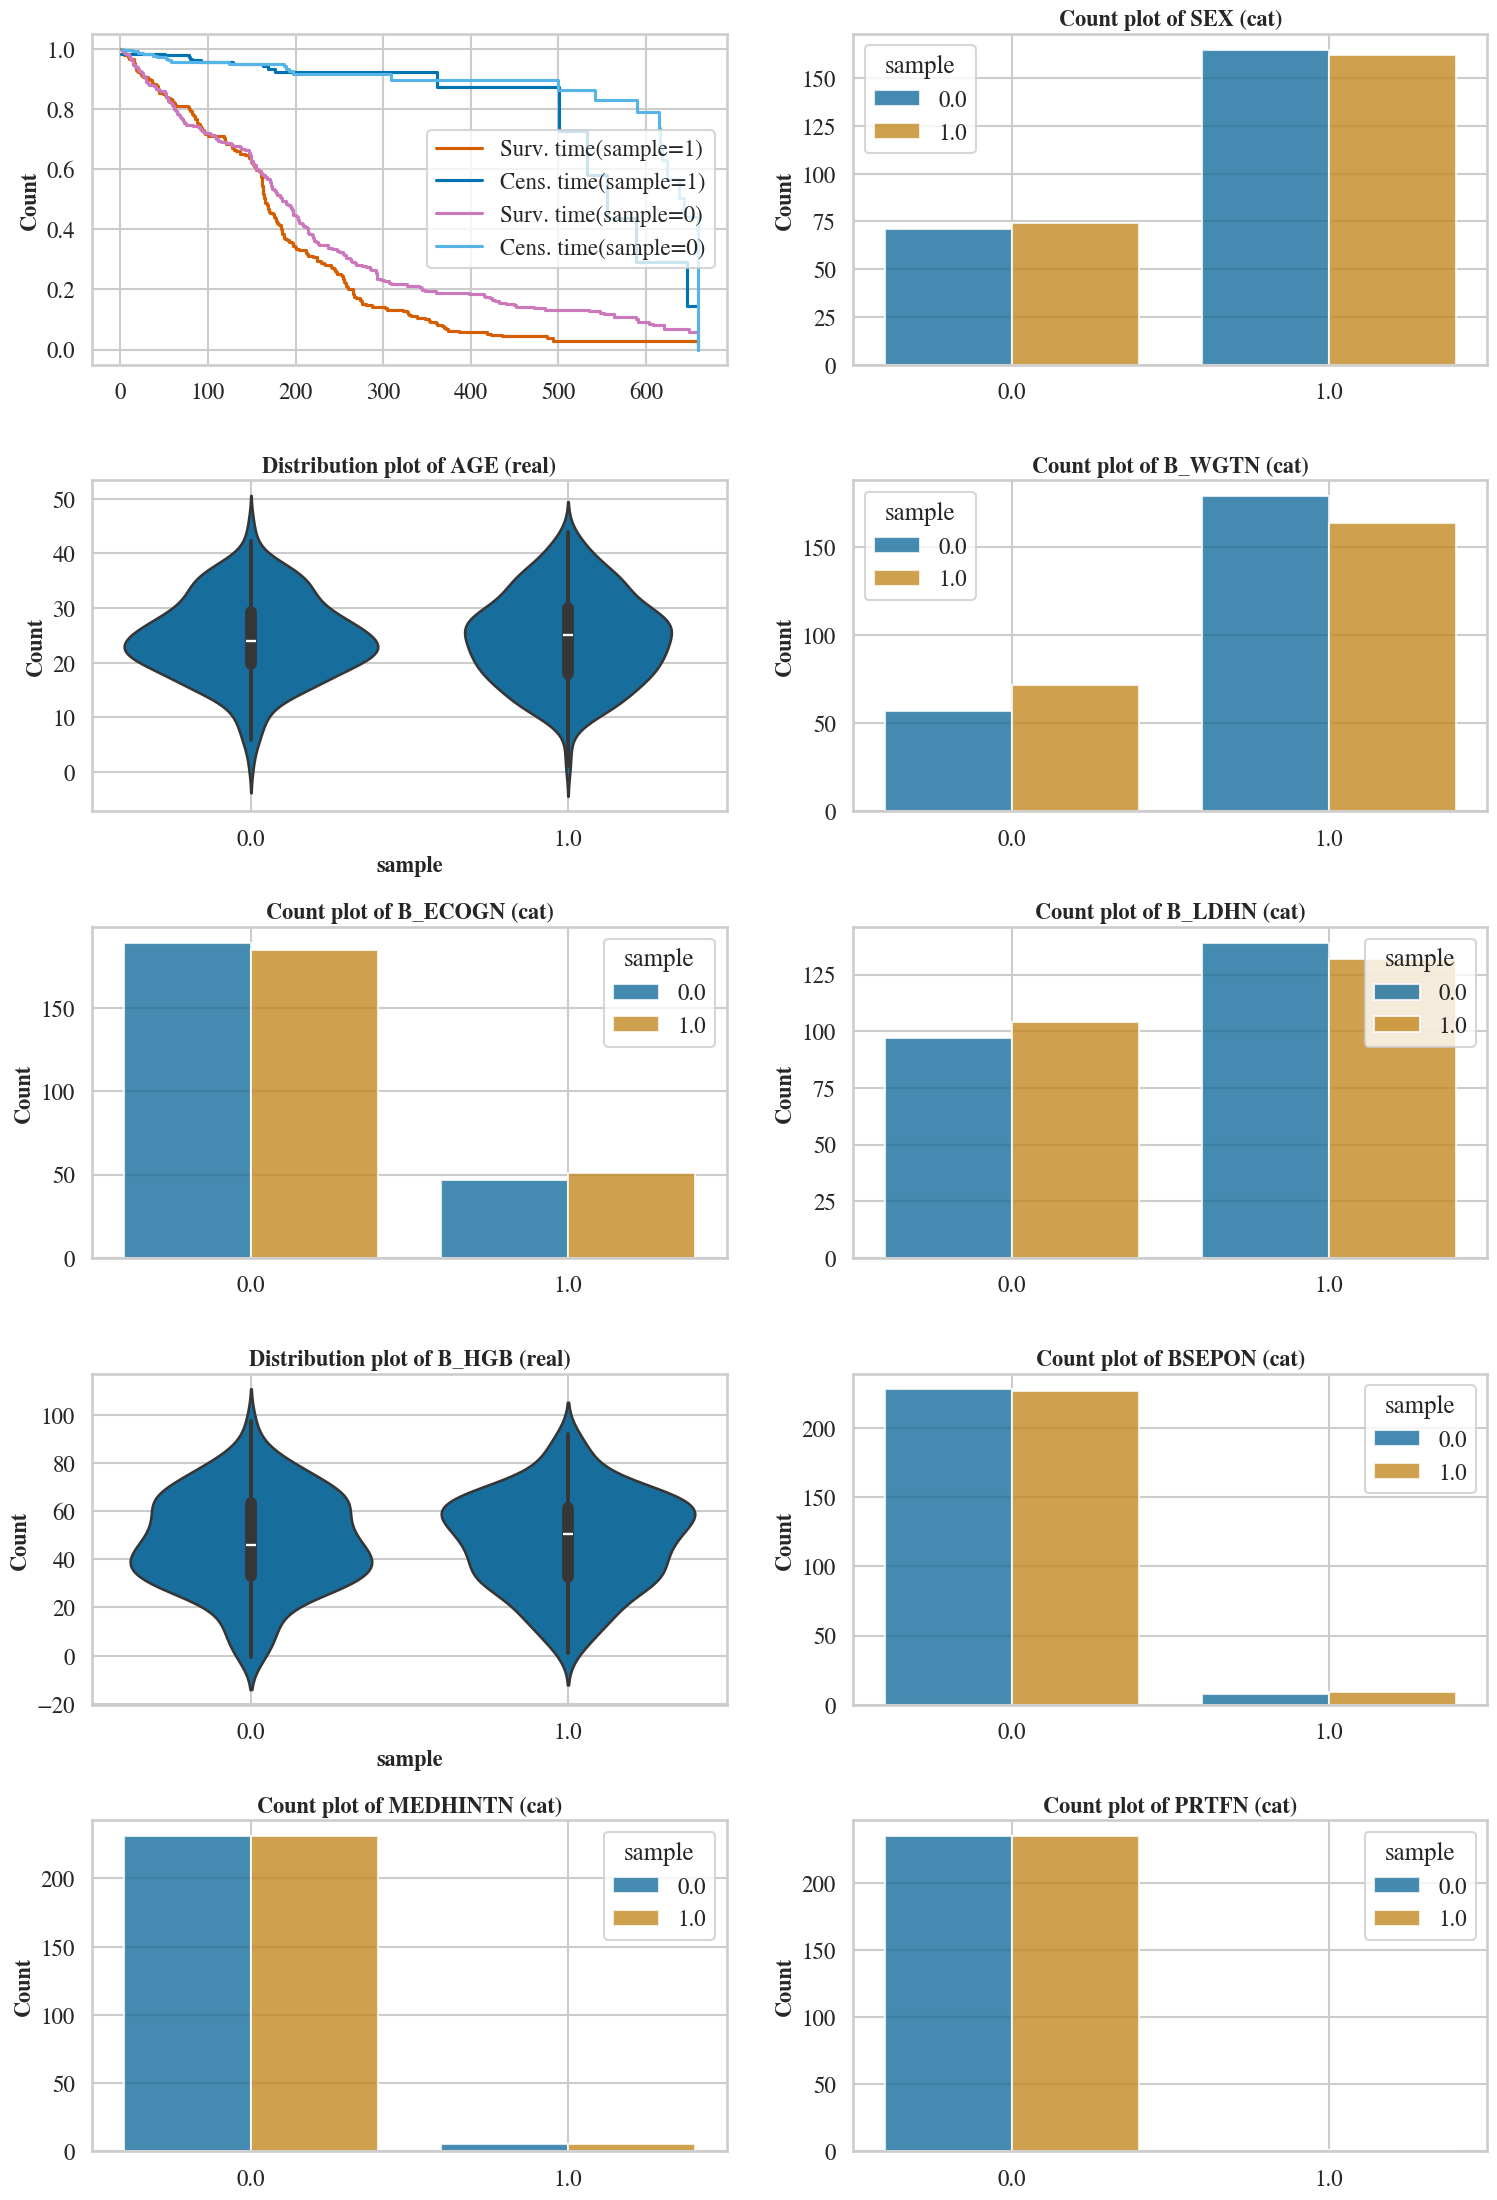

In [11]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)
df_init_control_ext['sample'] = 1

sel_idx = 2
df_gen_control_ext_sel = pd.DataFrame(data_gen_control[sel_idx].numpy(), columns=control_fnames)
df_gen_control_ext_sel['sample'] = 0

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [12]:
categorical = ['censor', 'SEX', 'B_WGTN', 'B_ECOGN', 'B_LDHN', 'BSEPON', 'MEDHINTN', 'PRTFN', 'sample']
continuous = ['time', 'AGE', 'B_HGB']
nonnormal = ['time']
table1 = TableOne(df_control_sel, categorical=categorical, continuous=continuous, groupby='sample', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by sample                                                                    
                                   Missing             Overall                   0                   1 P-Value
n                                                          472                 236                 236        
time, median [Q1,Q3]                     0  167.1 [78.0,255.1]  177.0 [66.3,282.0]  163.0 [83.8,242.5]   0.110
censor, n (%)        0.0                             49 (10.4)           30 (12.7)            19 (8.1)   0.131
                     1.0                            423 (89.6)          206 (87.3)          217 (91.9)        
SEX, n (%)           0.0                            145 (30.7)           71 (30.1)           74 (31.4)   0.842
                     1.0                            327 (69.3)          165 (69.9)          162 (68.6)        
AGE, mean (SD)                           0          24.4 (7.9)          24.4 (7.6)          24.4 (8.2)   0.987
B

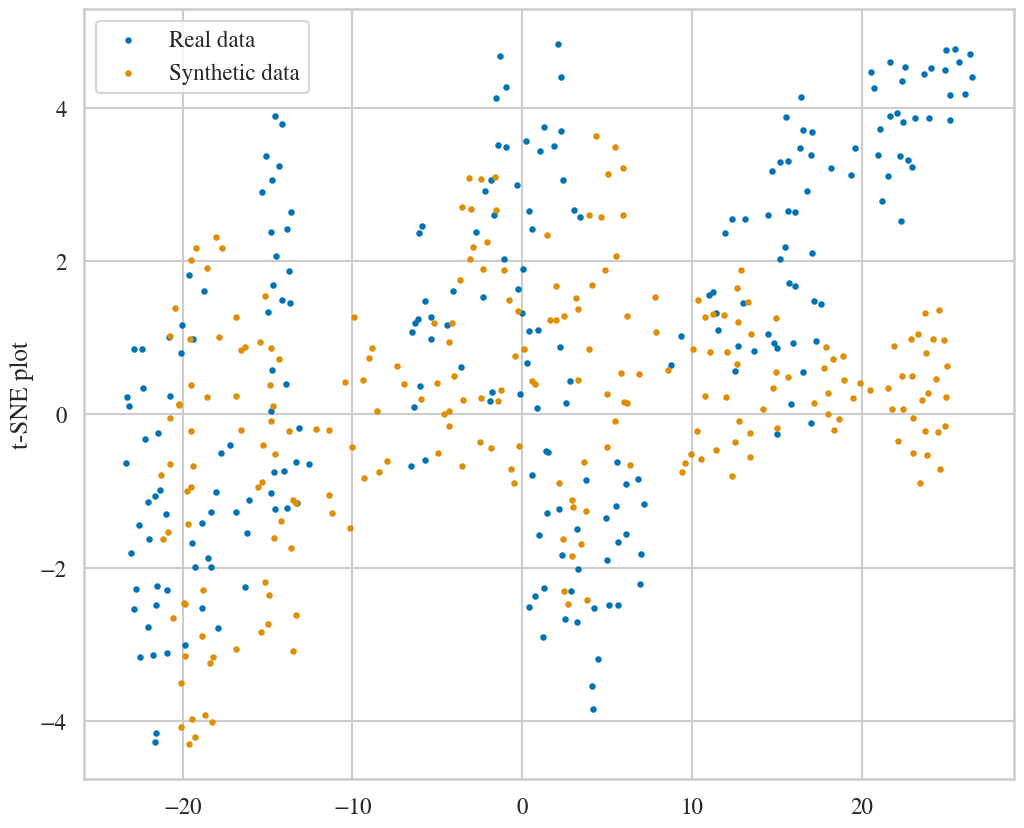

In [13]:
synthcity_dataloader_init = SurvivalAnalysisDataLoader(df_init_control, target_column = "censor", time_to_event_column = "time")
synthcity_dataloader_syn = SurvivalAnalysisDataLoader(df_gen_control_ext_sel, target_column = "censor", time_to_event_column = "time")
plot_tsne(plt, synthcity_dataloader_init, synthcity_dataloader_syn)

### 3.2. Statistical analysis: one generated control group vs. initial treated data

In [14]:
list_df_gen_control = []
for j in range(n_generated_dataset):
    df_gen_control_j = pd.DataFrame(data_gen_control[j].numpy(), columns=control_fnames)
    df_gen_control_j['treatment'] = 0
    list_df_gen_control.append(df_gen_control_j)

sel_idx = 0
df_gen_control_sel = list_df_gen_control[sel_idx]
df_syn_sel = pd.concat([df_init_treated, df_gen_control_sel], ignore_index=True)

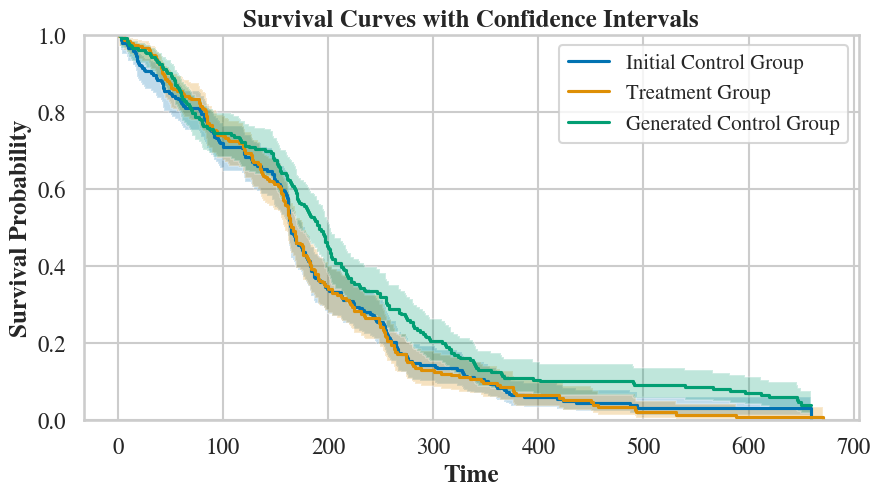

In [15]:
surv_time_control_init = df_init[df_init['treatment']==0].to_numpy()[:,0]
surv_ind_control_init = df_init[df_init['treatment']==0].to_numpy()[:,1].astype(bool)
surv_time_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,0]
surv_ind_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,1].astype(bool)
surv_time_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,0]
surv_ind_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,1].astype(bool)

uniq_time_control_init, surv_prob_control_init, conf_int_control_init = kaplan_meier_estimator(surv_ind_control_init, surv_time_control_init, conf_type="log-log")
uniq_time_treated_init, surv_prob_treated_init, conf_int_treated_init = kaplan_meier_estimator(surv_ind_treated_init, surv_time_treated_init, conf_type="log-log")
uniq_time_control_gen, surv_prob_control_gen, conf_int_control_gen = kaplan_meier_estimator(surv_ind_control_gen, surv_time_control_gen, conf_type="log-log")

plt.figure(figsize=(10, 5))
plt.step(uniq_time_control_init, surv_prob_control_init, where="post", label="Initial Control Group")
plt.fill_between(uniq_time_control_init, conf_int_control_init[0], conf_int_control_init[1], alpha=0.25, step="post")

plt.step(uniq_time_treated_init, surv_prob_treated_init, where="post", label="Treatment Group")
plt.fill_between(uniq_time_treated_init, conf_int_treated_init[0], conf_int_treated_init[1], alpha=0.25, step="post")

plt.step(uniq_time_control_gen, surv_prob_control_gen, where="post", label="Generated Control Group")
plt.fill_between(uniq_time_control_gen, conf_int_control_gen[0], conf_int_control_gen[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.xlabel("Time", fontweight="semibold")
plt.ylabel("Survival Probability", fontweight="semibold")
plt.title("Survival Curves with Confidence Intervals", fontweight="bold")
plt.show()

In [16]:
categorical = ['censor', 'SEX', 'B_WGTN', 'B_ECOGN', 'B_LDHN', 'BSEPON', 'MEDHINTN', 'PRTFN', 'treatment']
continuous = ['time', 'AGE', 'B_HGB']
nonnormal = ['time']
table1 = TableOne(df_syn_sel, categorical=categorical, continuous=continuous, groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by treatment                                                                    
                                      Missing             Overall                   0                   1 P-Value
n                                                             471                 236                 235        
time, median [Q1,Q3]                        0  168.4 [80.1,249.0]  171.8 [67.6,257.7]  163.0 [86.0,234.5]   0.523
censor, n (%)        0.0                                55 (11.7)           37 (15.7)            18 (7.7)   0.010
                     1.0                               416 (88.3)          199 (84.3)          217 (92.3)        
SEX, n (%)           0.0                               151 (32.1)           66 (28.0)           85 (36.2)   0.070
                     1.0                               320 (67.9)          170 (72.0)          150 (63.8)        
AGE, mean (SD)                              0          23.5 (8.2)          23.1 (7.3)   

## 4. Testing

### 4.1. Univariate testing

In [17]:
from utils.metrics import log_rank, cox_estimation

data_syn = []
for i in range(n_generated_dataset):
    df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control['treatment'] = 0
    data_syn.append(pd.concat([df_init_treated, df_gen_control], ignore_index=True))

LR_init, LR_syn = log_rank(df_init, data_syn)
coef_init, coef_syn, cox_p_value_init, cox_p_value_syn = cox_estimation(df_init, data_syn)

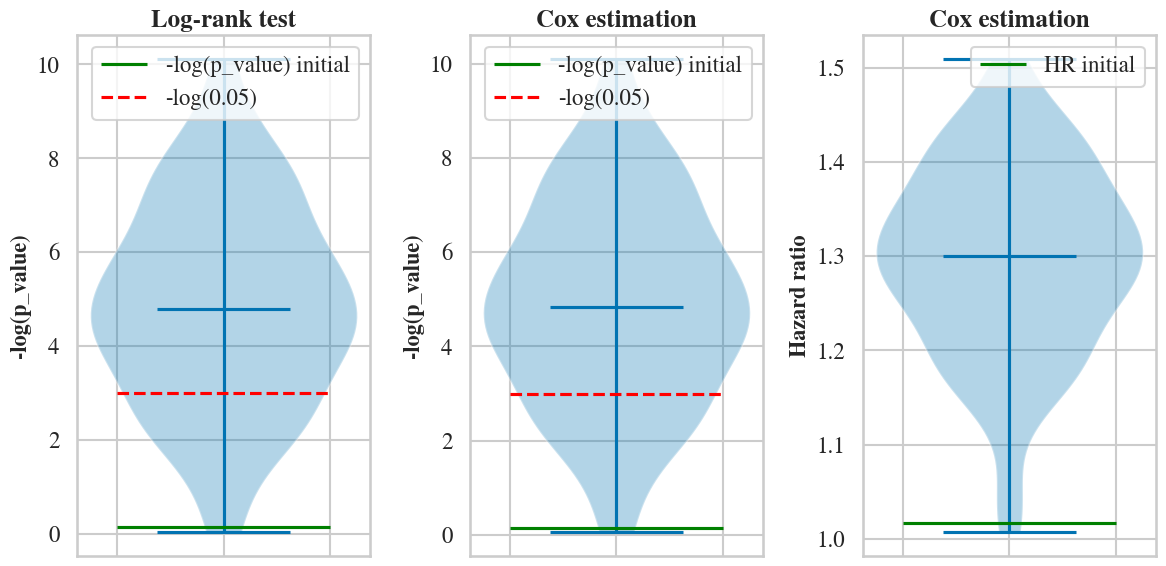

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.2. Stratified testing

#### 4.2.1. Categorical variable

In [19]:
from utils.metrics import strata_log_rank, strata_cox_estimation

# Stratified w.r. karnof analysis
strata_var = 'SEX'
df_init_strata = df_init.copy(deep=True)
df_init_treated_strata = df_init_treated.copy(deep=True)

data_syn_strata = []
for i in range(n_generated_dataset):
    df_gen_control_strata = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control_strata['treatment'] = 0
    data_syn_strata.append(pd.concat([df_init_treated_strata, df_gen_control_strata], ignore_index=True))

strata_LR_init, strata_LR_syn = strata_log_rank(df_init_strata, data_syn_strata, strata=strata_var)
strata_coef_init, strata_coef_syn, strata_cox_p_value_init, strata_cox_p_value_syn = strata_cox_estimation(df_init_strata, data_syn_strata, strata=strata_var)

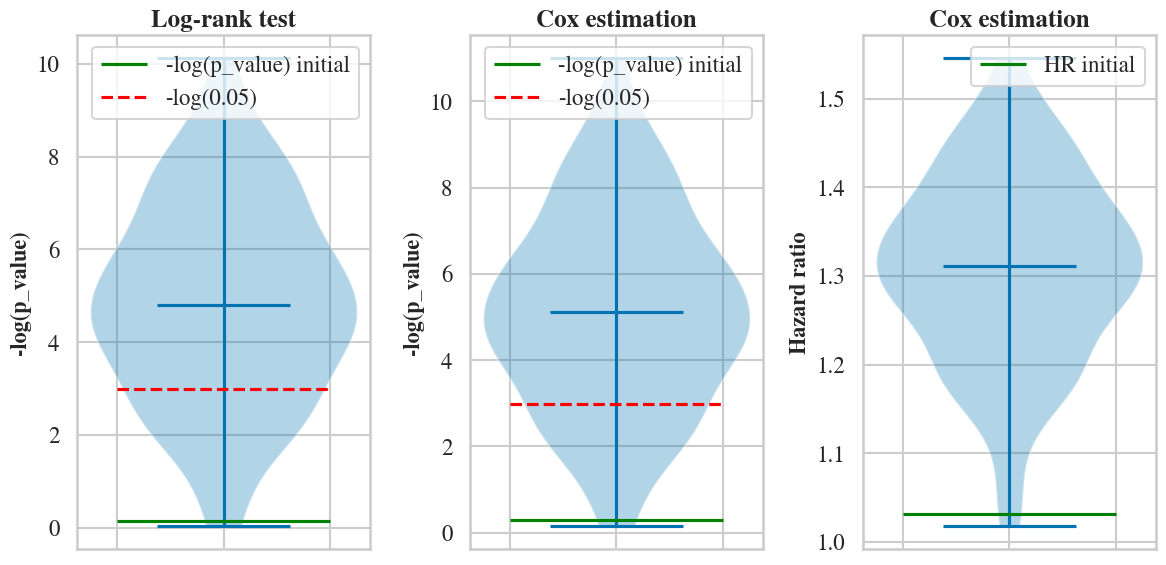

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(strata_LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(strata_LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(strata_cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(strata_cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(strata_coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(strata_coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.3. Metrics form synthcity: initial control data vs. all generated synthetic control groups

In [21]:
# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column

metrics = {
    'sanity': ['nearest_syn_neighbor_distance'],
    'stats': ['jensenshannon_dist', 'ks_test', 'survival_km_distance'],
    'performance': ['feat_rank_distance'],
    'detection': ['detection_xgb'],
    'privacy': ['k-map', 'distinct l-diversity', 'identifiability_score']
}
scores = ScoreEvaluator()
for j in range(n_generated_dataset):
    enable_reproducible_results(j)
    clear_cache()

    synthcity_dataloader_syn = SurvivalAnalysisDataLoader(list_df_gen_control[j], 
                                       target_column = "censor", 
                                       time_to_event_column = "time")

    evaluation = Metrics().evaluate(X_gt=synthcity_dataloader_init, # can be dataloaders or dataframes
                                    X_syn=synthcity_dataloader_syn, 
                                    reduction='mean', # default mean
                                    n_histogram_bins=10, # default 10
                                    metrics=metrics, # all metrics
                                    task_type='survival_analysis', 
                                    use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores.add(key, mean_score[key], errors[key], duration[key], direction[key])

synthcity_score = scores.to_dataframe()
synthcity_score

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.nearest_syn_neighbor_distance.mean,0.130643,0.329462,0.223308,0.046143,0.230542,0.072726,100,0,0.0,minimize
stats.jensenshannon_dist.marginal,0.004197,0.009488,0.006164,0.000909,0.006136,0.001020,100,0,0.0,minimize
stats.ks_test.marginal,0.948093,0.970339,0.960554,0.004729,0.961158,0.005385,100,0,0.0,maximize
stats.survival_km_distance.optimism,-0.004323,0.087935,0.049518,0.018916,0.050229,0.022213,100,0,0.0,minimize
stats.survival_km_distance.abs_optimism,0.017844,0.089942,0.054594,0.015093,0.053533,0.021788,100,0,0.0,minimize
stats.survival_km_distance.sightedness,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100,0,0.0,minimize
detection.detection_xgb.mean,0.650071,0.756785,0.710489,0.023794,0.712687,0.030780,100,0,0.0,minimize
privacy.k-map.score,2.000000,9.000000,5.620000,1.641828,6.000000,3.000000,100,0,0.0,maximize
privacy.distinct l-diversity.gt,3.000000,3.000000,3.000000,0.000000,3.000000,0.000000,100,0,0.0,maximize
privacy.distinct l-diversity.syn,1.000000,8.000000,4.200000,1.536229,4.000000,2.000000,100,0,0.0,maximize
